In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# ==== PATH & IMPORTS ====
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, confusion_matrix
)
import itertools

# 路径模式: "colab" / "local"
BASE_PATH_MODE = "colab"
if BASE_PATH_MODE == "colab":
    BASE_DIR = Path("/content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_small")
else:
    BASE_DIR = Path("./HRI-EMO-results/mosei_fusion_decoder_small")

CKPT = BASE_DIR / "best_mosei_fusion_decoder.pt"
OUT_DIR = BASE_DIR / "infer_outputs"
EMO = ["emo_happy","emo_sad","emo_anger","emo_fear","emo_disgust","emo_surprise"]

# 用哪个 split
SPLIT = "test"  # or "val"

# 读概率 & 标签
y_prob = np.load(OUT_DIR / f"{SPLIT}_y_prob.npy")
y_true_cont = np.load(OUT_DIR / f"{SPLIT}_y_true.npy")
y_true = (y_true_cont > 0).astype(int)

# 读阈值（训练时保存的校准阈值）
ckpt = torch.load(CKPT, map_location="cpu")
thresholds = np.array(ckpt.get("val_calibrated_thresholds", [0.5]*len(EMO)), dtype=float)

# 基本指标函数
def overall_metrics(y_true, y_prob, thresholds):
    y_pred = (y_prob >= thresholds[None,:]).astype(int)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    aucs = []
    for i in range(y_true.shape[1]):
        if y_true[:,i].max()>0 and y_true[:,i].min()<1:
            aucs.append(roc_auc_score(y_true[:,i], y_prob[:,i]))
    macro_auc = float(np.mean(aucs)) if aucs else 0.0
    return micro, macro, macro_auc

micro, macro, macro_auc = overall_metrics(y_true, y_prob, thresholds)
print(f"[{SPLIT.upper()}] micro-F1={micro:.4f} | macro-F1={macro:.4f} | macro-AUC={macro_auc:.4f}")


[TEST] micro-F1=0.5054 | macro-F1=0.3971 | macro-AUC=0.6687


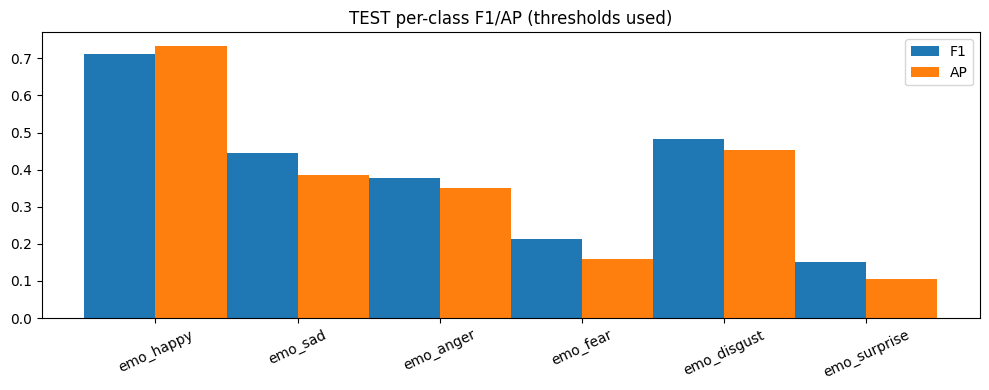

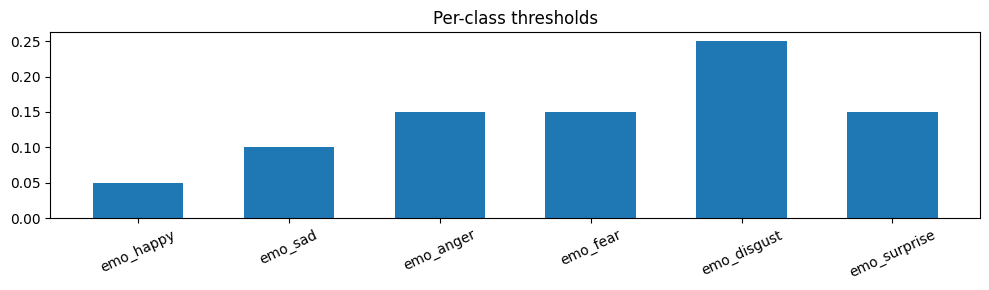

In [18]:
from sklearn.metrics import average_precision_score

f1s, aps = [], []
y_pred = (y_prob >= thresholds[None,:]).astype(int)
for i in range(len(EMO)):
    f1s.append(f1_score(y_true[:,i], y_pred[:,i], zero_division=0))
    aps.append(average_precision_score(y_true[:,i], y_prob[:,i]))

x = np.arange(len(EMO))
plt.figure(figsize=(10,4))
plt.bar(x-0.25, f1s, width=0.5, label="F1")
plt.bar(x+0.25, aps, width=0.5, label="AP")
plt.xticks(x, EMO, rotation=25)
plt.title(f"{SPLIT.upper()} per-class F1/AP (thresholds used)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.bar(x, thresholds, width=0.6)
plt.xticks(x, EMO, rotation=25)
plt.title("Per-class thresholds")
plt.tight_layout(); plt.show()


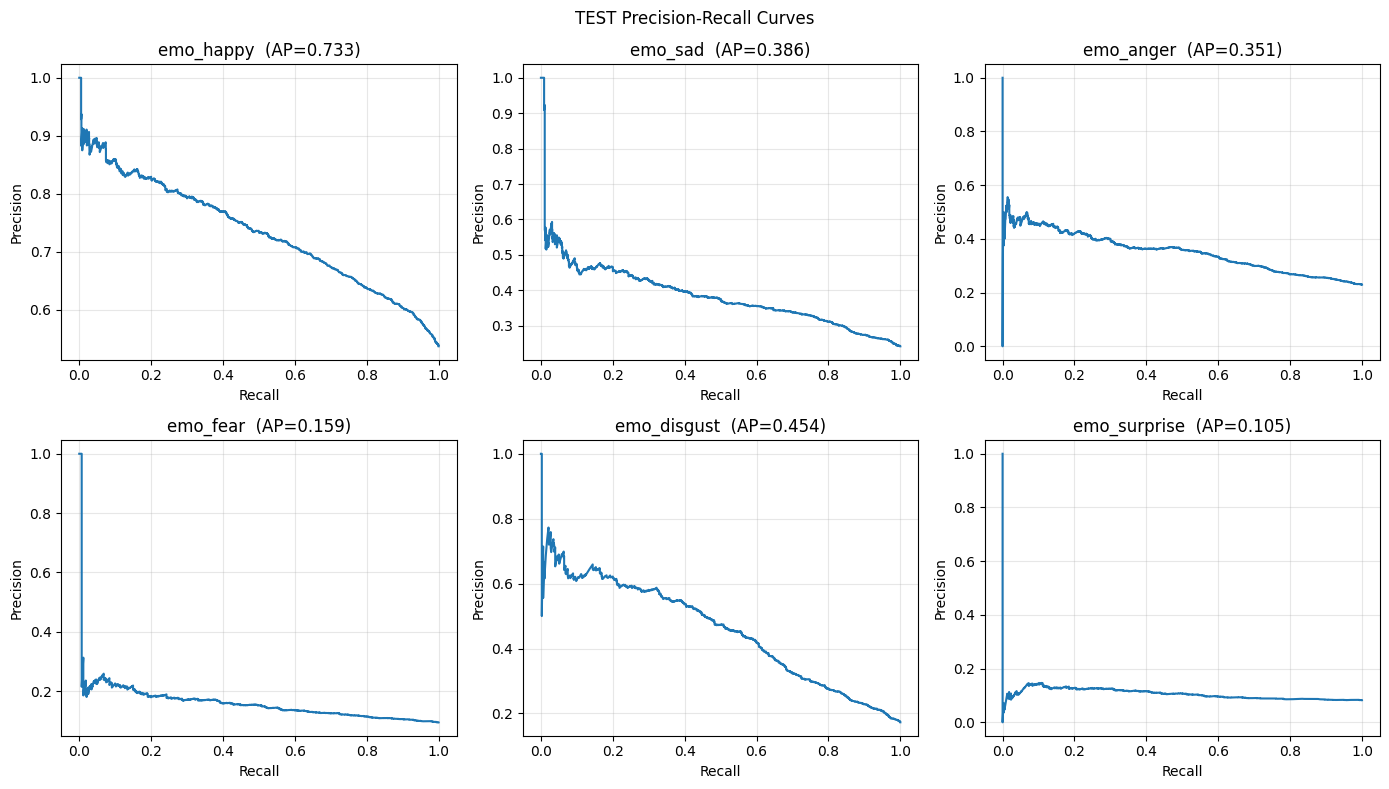

In [19]:
cols = 3
rows = int(np.ceil(len(EMO)/cols))
plt.figure(figsize=(14, 8))
for i, name in enumerate(EMO):
    plt.subplot(rows, cols, i+1)
    p, r, _ = precision_recall_curve(y_true[:,i], y_prob[:,i])
    ap = average_precision_score(y_true[:,i], y_prob[:,i])
    plt.plot(r, p)
    plt.title(f"{name}  (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.grid(True, alpha=0.3)
plt.suptitle(f"{SPLIT.upper()} Precision-Recall Curves")
plt.tight_layout(); plt.show()


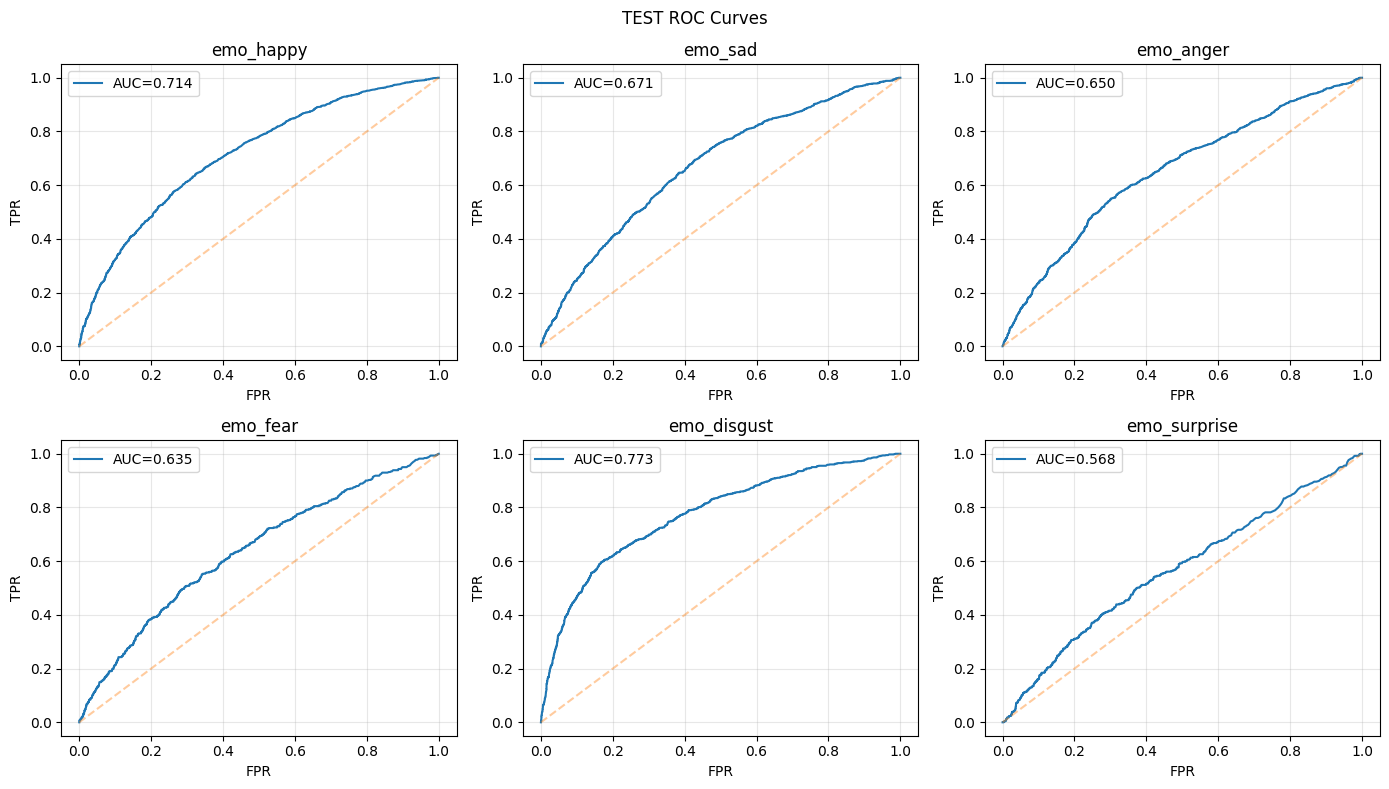

In [20]:
cols = 3
rows = int(np.ceil(len(EMO)/cols))
plt.figure(figsize=(14, 8))
for i, name in enumerate(EMO):
    plt.subplot(rows, cols, i+1)
    if y_true[:,i].max()>0 and y_true[:,i].min()<1:
        fpr, tpr, _ = roc_curve(y_true[:,i], y_prob[:,i])
        auc = roc_auc_score(y_true[:,i], y_prob[:,i])
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1],[0,1], "--", alpha=0.4)
        plt.legend()
    plt.title(name); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.grid(True, alpha=0.3)
plt.suptitle(f"{SPLIT.upper()} ROC Curves")
plt.tight_layout(); plt.show()


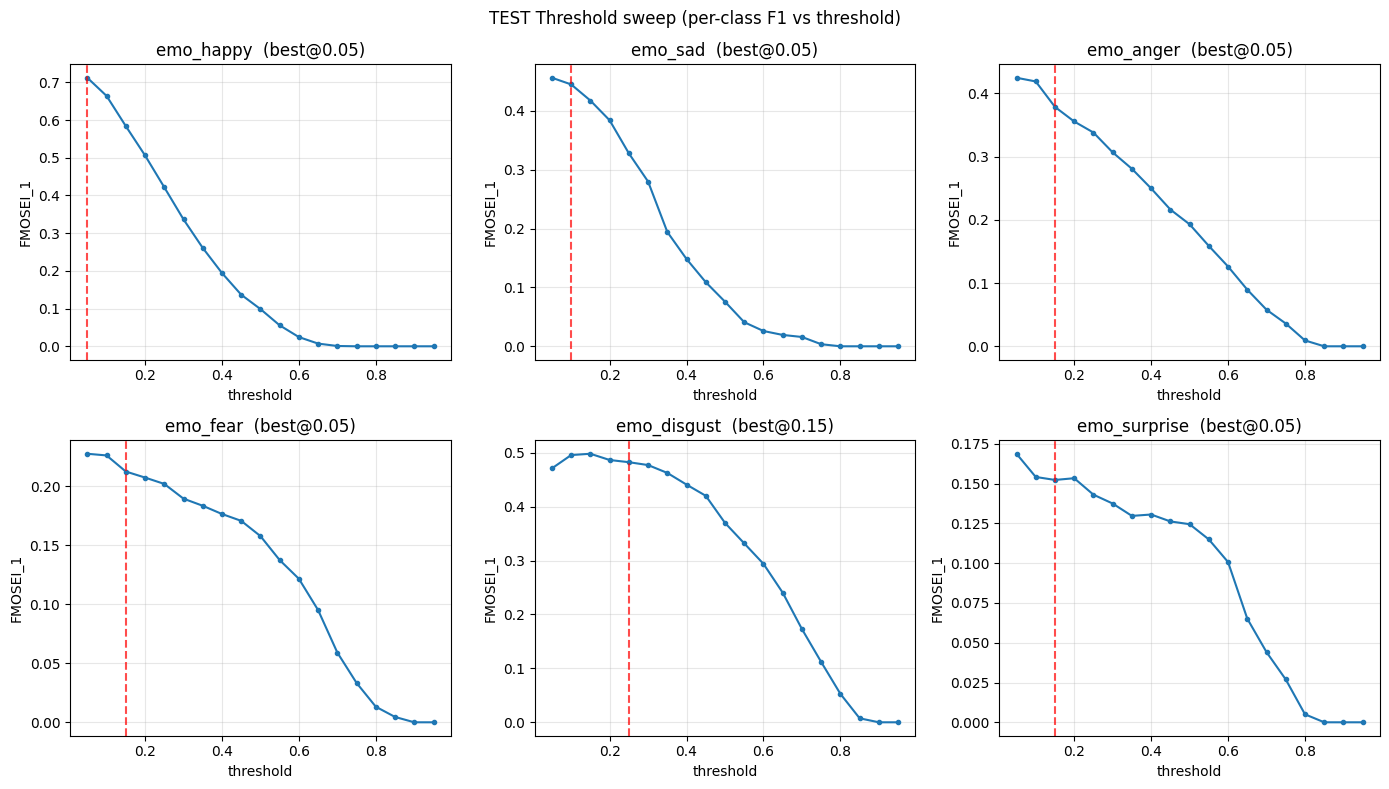

In [21]:
ths = np.linspace(0.05, 0.95, 19)
cols = 3
rows = int(np.ceil(len(EMO)/cols))
plt.figure(figsize=(14, 8))
for i, name in enumerate(EMO):
    plt.subplot(rows, cols, i+1)
    f1_list = []
    for t in ths:
        pred = (y_prob[:,i] >= t).astype(int)
        f1_list.append(f1_score(y_true[:,i], pred, zero_division=0))
    plt.plot(ths, f1_list, marker="o", ms=3)
    # 标注当前使用的阈值位置
    plt.axvline(thresholds[i], color="r", linestyle="--", alpha=0.7)
    plt.title(f"{name}  (best@{ths[np.argmax(f1_list)]:.2f})")
    plt.xlabel("threshold"); plt.ylabel("FMOSEI_1"); plt.grid(True, alpha=0.3)
plt.suptitle(f"{SPLIT.upper()} Threshold sweep (per-class F1 vs threshold)")
plt.tight_layout(); plt.show()


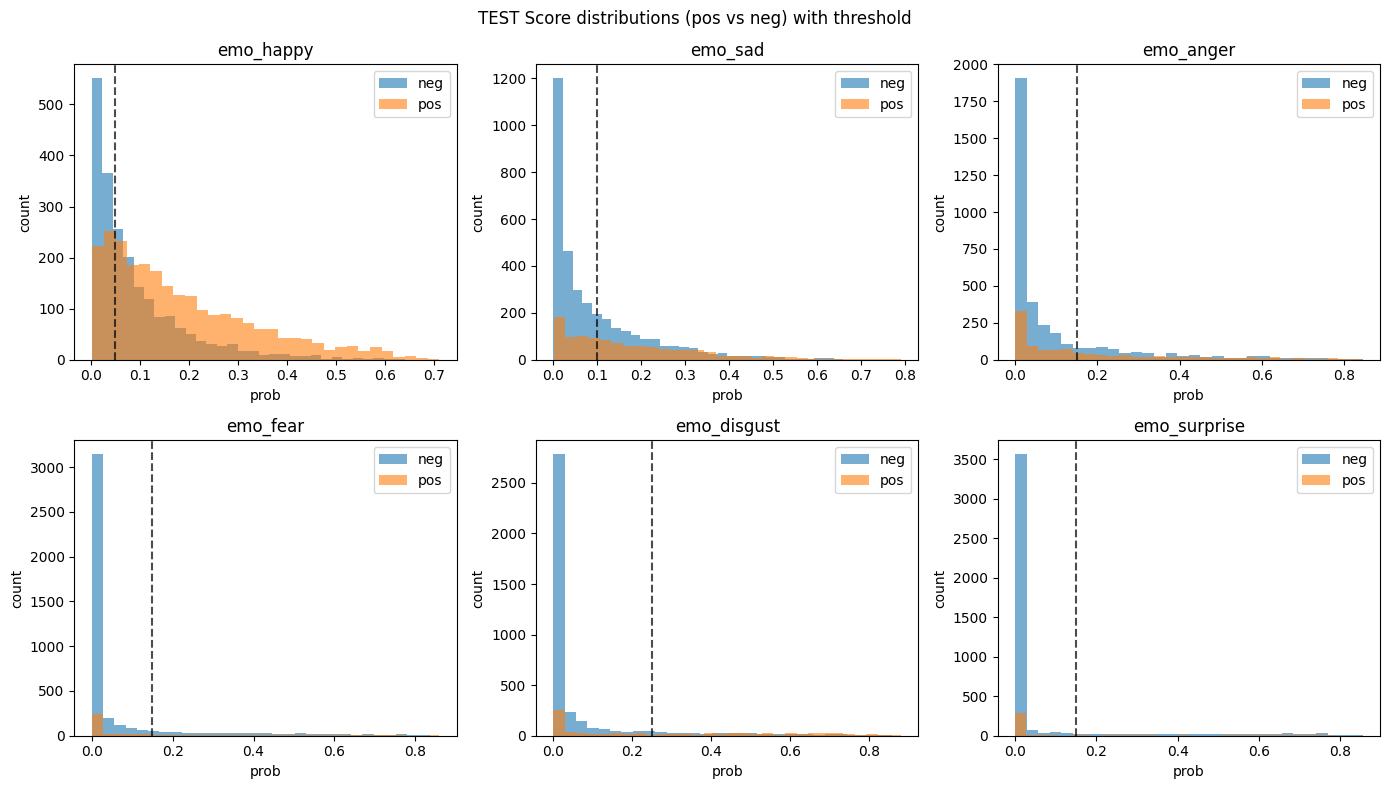

In [22]:
cols = 3
rows = int(np.ceil(len(EMO)/cols))
plt.figure(figsize=(14, 8))
for i, name in enumerate(EMO):
    plt.subplot(rows, cols, i+1)
    pos = y_prob[y_true[:,i]==1, i]
    neg = y_prob[y_true[:,i]==0, i]
    plt.hist(neg, bins=30, alpha=0.6, label="neg")
    plt.hist(pos, bins=30, alpha=0.6, label="pos")
    plt.axvline(thresholds[i], color="k", linestyle="--", alpha=0.7)
    plt.title(name); plt.xlabel("prob"); plt.ylabel("count"); plt.legend()
plt.suptitle(f"{SPLIT.upper()} Score distributions (pos vs neg) with threshold")
plt.tight_layout(); plt.show()


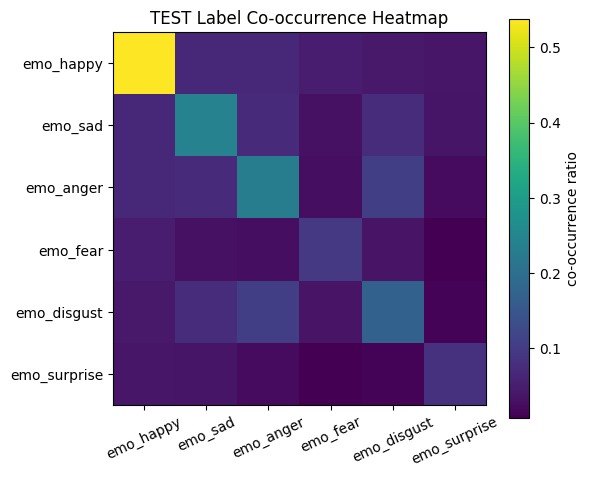

In [23]:
# 计算标签共现（同一样本两个情绪同时为1的比例）
co_mat = np.zeros((len(EMO), len(EMO)), dtype=float)
n = y_true.shape[0]
for i in range(len(EMO)):
    for j in range(len(EMO)):
        co_mat[i,j] = np.sum((y_true[:,i]==1) & (y_true[:,j]==1)) / n

plt.figure(figsize=(6,5))
plt.imshow(co_mat, cmap="viridis")
plt.colorbar(label="co-occurrence ratio")
plt.xticks(range(len(EMO)), EMO, rotation=25)
plt.yticks(range(len(EMO)), EMO)
plt.title(f"{SPLIT.upper()} Label Co-occurrence Heatmap")
plt.tight_layout(); plt.show()


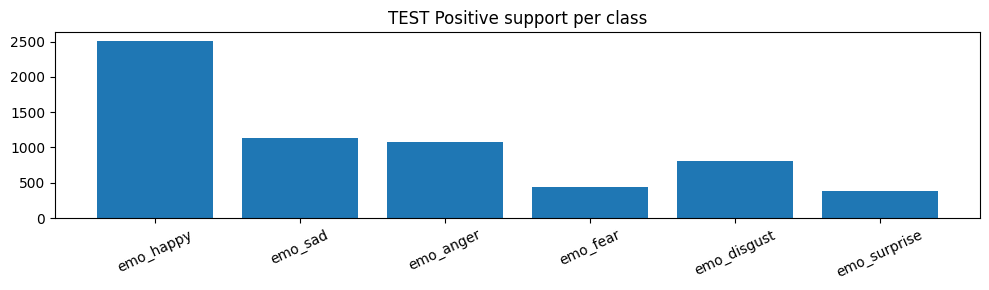

In [24]:
supports = y_true.sum(axis=0)
plt.figure(figsize=(10,3))
plt.bar(np.arange(len(EMO)), supports)
plt.xticks(np.arange(len(EMO)), EMO, rotation=25)
plt.title(f"{SPLIT.upper()} Positive support per class")
plt.tight_layout(); plt.show()


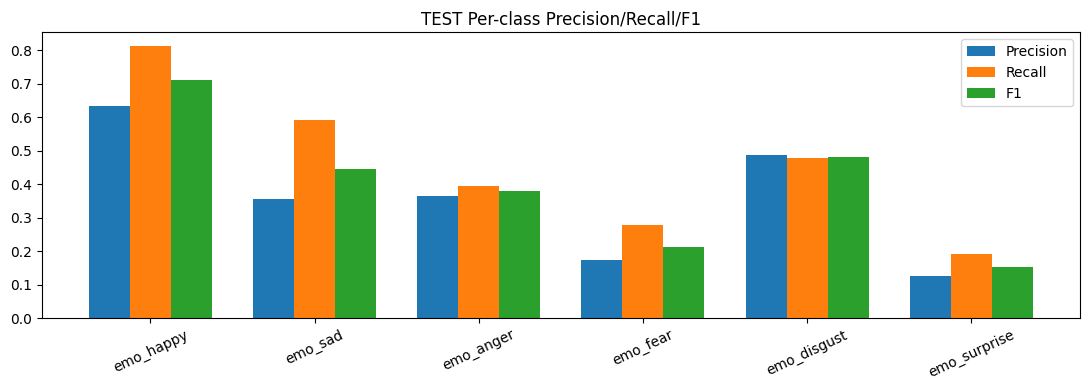

In [25]:
precisions, recalls, f1s = [], [], []
for i in range(len(EMO)):
    pred = y_pred[:,i]
    true = y_true[:,i]
    tp = np.sum((pred==1) & (true==1))
    fp = np.sum((pred==1) & (true==0))
    fn = np.sum((pred==0) & (true==1))
    precision = tp / (tp+fp) if (tp+fp)>0 else 0.0
    recall    = tp / (tp+fn) if (tp+fn)>0 else 0.0
    f1        = f1_score(true, pred, zero_division=0)
    precisions.append(precision); recalls.append(recall); f1s.append(f1)

x = np.arange(len(EMO))
plt.figure(figsize=(11,4))
plt.bar(x-0.25, precisions, width=0.25, label="Precision")
plt.bar(x,       recalls,   width=0.25, label="Recall")
plt.bar(x+0.25,  f1s,       width=0.25, label="F1")
plt.xticks(x, EMO, rotation=25); plt.legend()
plt.title(f"{SPLIT.upper()} Per-class Precision/Recall/F1")
plt.tight_layout(); plt.show()


In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ====== 路径配置 ======
# Colab 默认：用你现在的结果目录
BASE_DIR = "/content/drive/MyDrive/ColabNotebooks/beta_decoder_project/HRI-EMO-results/mosei_fusion_decoder_small/infer_outputs"

# 如果在本地 / 服务器，就把上面改成本地路径：
# BASE_DIR = "/home/xxx/projects/HRI-EMO-results/mosei_fusion_decoder_small/infer_outputs"

val_beta = np.load(os.path.join(BASE_DIR, "val_beta_mean.npy"))
test_beta = np.load(os.path.join(BASE_DIR, "test_beta_mean.npy"))

print("val_beta shape:", val_beta.shape)
print("test_beta shape:", test_beta.shape)
print("val_beta:  mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
    val_beta.mean(), val_beta.std(), val_beta.min(), val_beta.max()
))
print("test_beta: mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
    test_beta.mean(), test_beta.std(), test_beta.min(), test_beta.max()
))


val_beta shape: (1871,)
test_beta shape: (4662,)
val_beta:  mean=0.3401, std=0.0238, min=0.2856, max=0.4075
test_beta: mean=0.3398, std=0.0243, min=0.2837, max=0.4038


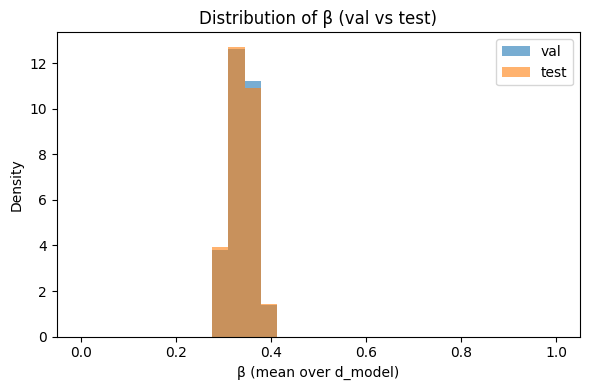

In [27]:
plt.figure(figsize=(6,4))
bins = np.linspace(0, 1, 30)

plt.hist(val_beta, bins=bins, alpha=0.6, density=True, label="val")
plt.hist(test_beta, bins=bins, alpha=0.6, density=True, label="test")

plt.xlabel("β (mean over d_model)")
plt.ylabel("Density")
plt.title("Distribution of β (val vs test)")
plt.legend()
plt.tight_layout()
plt.show()


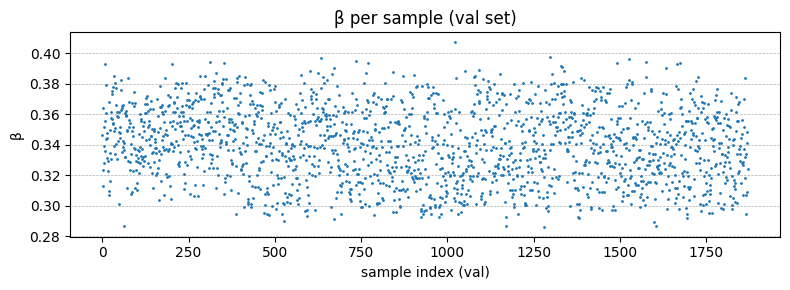

In [28]:
plt.figure(figsize=(8,3))
plt.plot(val_beta, ".", markersize=2)
plt.xlabel("sample index (val)")
plt.ylabel("β")
plt.title("β per sample (val set)")
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1404683387.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([val_beta, test_beta], labels=["val", "test"], showfliers=False)


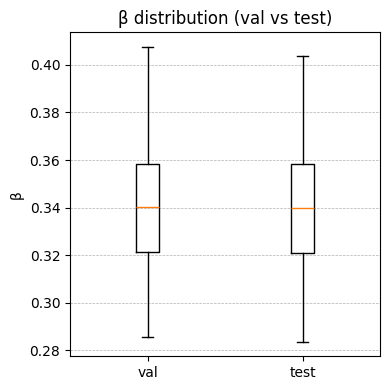

In [29]:
plt.figure(figsize=(4,4))
plt.boxplot([val_beta, test_beta], labels=["val", "test"], showfliers=False)
plt.ylabel("β")
plt.title("β distribution (val vs test)")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


happy  positive: mean β=0.3376, n=1005
happy  negative: mean β=0.3431, n=866


/tmp/ipython-input-1110912837.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([beta_pos, beta_neg], labels=[f"{EMO[emo_idx]}=1", f"{EMO[emo_idx]}=0"], showfliers=False)


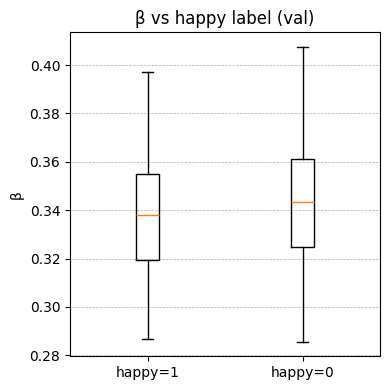

In [31]:
# 加载标签
val_y_true = np.load(os.path.join(BASE_DIR, "val_y_true.npy"))  # [N, 6]
EMO = ["happy","sad","anger","fear","disgust","surprise"]

emo_idx = 0  # 比如看 happy
pos_mask = val_y_true[:, emo_idx] > 0
neg_mask = val_y_true[:, emo_idx] <= 0

beta_pos = val_beta[pos_mask]
beta_neg = val_beta[neg_mask]

print(f"{EMO[emo_idx]}  positive: mean β={beta_pos.mean():.4f}, n={beta_pos.size}")
print(f"{EMO[emo_idx]}  negative: mean β={beta_neg.mean():.4f}, n={beta_neg.size}")

plt.figure(figsize=(4,4))
plt.boxplot([beta_pos, beta_neg], labels=[f"{EMO[emo_idx]}=1", f"{EMO[emo_idx]}=0"], showfliers=False)
plt.ylabel("β")
plt.title(f"β vs {EMO[emo_idx]} label (val)")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()
